In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

torch.manual_seed(0)
torch.cuda.manual_seed(0)

def breaker():
    print("\n" + 50*"-" + "\n")

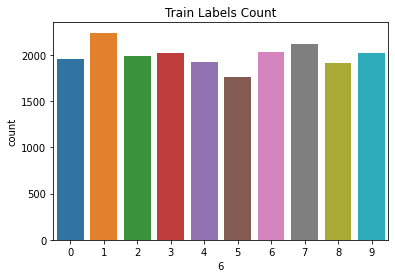

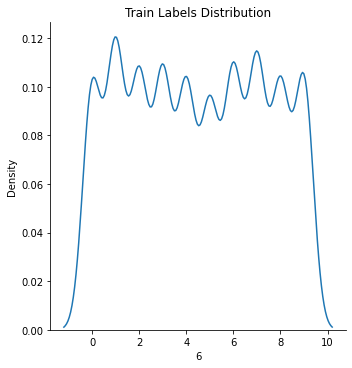

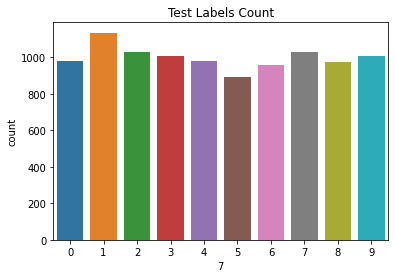

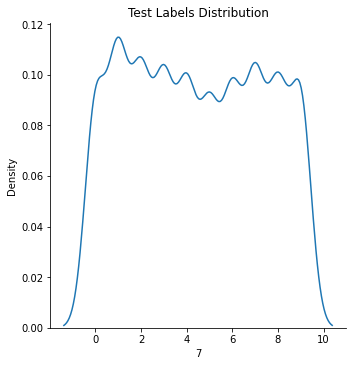

In [2]:
tr_data = pd.read_csv("/content/sample_data/mnist_train_small.csv")
ts_data = pd.read_csv("/content/sample_data/mnist_test.csv")

plt.figure()
sns.countplot(data=tr_data, x="6")
plt.title("Train Labels Count")
plt.show()
sns.displot(tr_data["6"], kind="kde")
plt.title("Train Labels Distribution")
plt.show()

plt.figure()
sns.countplot(data=ts_data, x="7")
plt.title("Test Labels Count")
plt.show()
sns.displot(ts_data["7"], kind="kde")
plt.title("Test Labels Distribution")
plt.show()

In [3]:
tr_features = tr_data.iloc[:, 1:].copy().values
tr_features = np.divide(tr_features, 255)
tr_labels   = tr_data.iloc[:, 0].copy().values

ts_features = ts_data.iloc[:, 1:].copy().values
ts_features = np.divide(ts_features, 255)
ts_labels   = ts_data.iloc[:, 0].copy().values

del tr_data, ts_data

print(gc.collect())

10841


In [4]:
class AEDS(Dataset):
    def __init__(this, X=None, y=None):
        this.X = X.reshape(X.shape[0], 1, 28, 28)
        this.y = y

    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tr_batch_size = 128
ts_batch_size = 128
epochs = 25 
code_size = 512

tr_data_setup = AEDS(tr_features, tr_labels.reshape(-1,1))
tr_data = DL(tr_data_setup, batch_size=tr_batch_size, shuffle=True)

ts_data_setup = AEDS(ts_features, ts_labels.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=ts_batch_size, shuffle=False)

# Convolutional Autoencoder

In [6]:
class CAE(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.latentlayer = nn.Sequential()
        this.latentlayer.add_module("Latent Layer", nn.Linear(in_features=256*3*3, out_features=code_size))
        this.latentlayer.add_module("Latent Activation", nn.ReLU())

        this.reverselatentlayer = nn.Sequential()
        this.reverselatentlayer.add_module("Latent Layer", nn.Linear(in_features=code_size, out_features=256*3*3))
        this.reverselatentlayer.add_module("Latent Activation", nn.ReLU())

        this.decoder = nn.Sequential()
        this.decoder.add_module("Deconvolution 1", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2))
        this.decoder.add_module("Activation 1", nn.ReLU())
        this.decoder.add_module("Deconvolution 2", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 2", nn.ReLU())
        this.decoder.add_module("Deactivation 3", nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 3", nn.Sigmoid())

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        x = this.encoder(x)
        x = x.view(x.shape[0], -1)
        x = this.latentlayer(x)
        x = this.reverselatentlayer(x)
        x = x.view(x.shape[0], 256, 3, 3)
        x = this.decoder(x)
        return x


--------------------------------------------------

Epoch: 1 | Training Loss: 0.06598 | Validation Loss: 0.01889
Epoch: 2 | Training Loss: 0.02359 | Validation Loss: 0.00978
Epoch: 3 | Training Loss: 0.01474 | Validation Loss: 0.00747
Epoch: 4 | Training Loss: 0.01174 | Validation Loss: 0.00568
Epoch: 5 | Training Loss: 0.00977 | Validation Loss: 0.00512
Epoch: 6 | Training Loss: 0.00876 | Validation Loss: 0.00443
Epoch: 7 | Training Loss: 0.00766 | Validation Loss: 0.00404
Epoch: 8 | Training Loss: 0.00722 | Validation Loss: 0.00412
Epoch: 9 | Training Loss: 0.00668 | Validation Loss: 0.00389
Epoch: 10 | Training Loss: 0.00623 | Validation Loss: 0.00352
Epoch: 11 | Training Loss: 0.00602 | Validation Loss: 0.00340
Epoch: 12 | Training Loss: 0.00556 | Validation Loss: 0.00340
Epoch: 13 | Training Loss: 0.00539 | Validation Loss: 0.00377
Epoch: 14 | Training Loss: 0.00521 | Validation Loss: 0.00311
Epoch: 15 | Training Loss: 0.00499 | Validation Loss: 0.00284
Epoch: 16 | Training Loss:

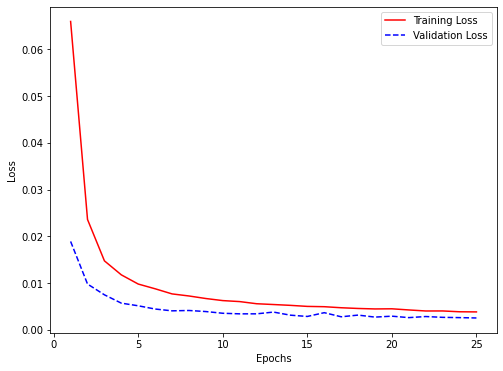

In [7]:
cae_model = CAE(code_size=code_size)
cae_model.to(device)
optimizer = cae_model.getOptimizer(lr=1e-3, wd=0)


breaker()
start_time = time()
LPT = []
LPV = []
for e in range(epochs):
    trainLossPerPass = 0
    valLossPerPass = 0

    cae_model.train()
    for X, y in tr_data:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        output = cae_model(X)
        loss = nn.MSELoss()(output, X)
        loss.backward()
        trainLossPerPass += (loss.item()/y.shape[0])
        optimizer.step()
    LPT.append(trainLossPerPass)

    cae_model.eval()
    for X, y in ts_data:
        X = X.to(device)
        with torch.no_grad():
            output = cae_model(X)
            loss = nn.MSELoss()(output, X)
            valLossPerPass += (loss.item()/X.shape[0])
    LPV.append(valLossPerPass)
    print("Epoch: {} | Training Loss: {:.5f} | Validation Loss: {:.5f}".format(e+1, trainLossPerPass, valLossPerPass))

breaker()
print("Time : {:.2f} seconds".format(time() - start_time))
breaker()

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

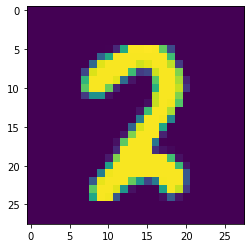

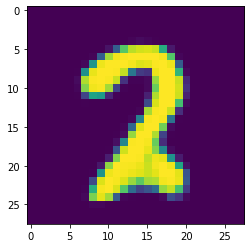

In [8]:
plt.figure()
plt.imshow(X[0, 0, :, :].detach().cpu().numpy())
plt.show()

plt.figure()
output = output.reshape(output.shape[0], 1, 28, 28)
plt.imshow(output[0, 0, :, :].detach().cpu().numpy())
plt.show()

**Evaluation**

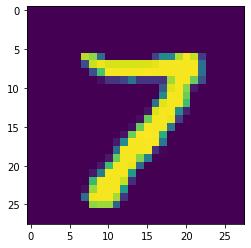

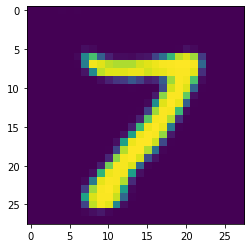

In [9]:
ts_x, ts_y = next(iter(ts_data))

sample_no = 33
plt.figure()
plt.imshow(ts_x[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

cae_model.eval()
recon_image = cae_model(ts_x.to(device))

plt.figure()
output = recon_image.reshape(recon_image.shape[0], 1, 28, 28)
plt.imshow(recon_image[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

for names, params in cae_model.named_parameters():
    params.requires_grad = False

# Classification

In [11]:
class CNN(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.latentlayer = nn.Sequential()
        this.latentlayer.add_module("Latent Layer", nn.Linear(in_features=256*3*3, out_features=code_size))
        this.latentlayer.add_module("Latent Activation", nn.ReLU())

        this.FC = nn.Linear(in_features=code_size, out_features=10)

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        x = this.encoder(x)
        x = x.view(x.shape[0], -1)
        x = this.latentlayer(x)
        x = F.log_softmax(this.FC(x), dim=1)
        return x

In [12]:
cnn_model = CNN(code_size=code_size)
cnn_model.to(device)

for names, params in cnn_model.named_parameters():
    params = cae_model.state_dict()[names]
    if names == "latentlayer.Latent Layer.bias":
        break
    
for names, params in cnn_model.named_parameters():
    params.requires_grad = False
    if names == "latentlayer.Latent Layer.bias":
        break


--------------------------------------------------

Epoch: 1 | Training Loss: 1.63172 | Validation Loss: 0.50117
Epoch: 2 | Training Loss: 0.74530 | Validation Loss: 0.30641
Epoch: 3 | Training Loss: 0.52973 | Validation Loss: 0.23516
Epoch: 4 | Training Loss: 0.43050 | Validation Loss: 0.19585
Epoch: 5 | Training Loss: 0.37566 | Validation Loss: 0.17049
Epoch: 6 | Training Loss: 0.32734 | Validation Loss: 0.15552
Epoch: 7 | Training Loss: 0.30246 | Validation Loss: 0.14209
Epoch: 8 | Training Loss: 0.27515 | Validation Loss: 0.13164
Epoch: 9 | Training Loss: 0.26641 | Validation Loss: 0.12541
Epoch: 10 | Training Loss: 0.24209 | Validation Loss: 0.11838
Epoch: 11 | Training Loss: 0.22825 | Validation Loss: 0.11472
Epoch: 12 | Training Loss: 0.21798 | Validation Loss: 0.10932
Epoch: 13 | Training Loss: 0.21070 | Validation Loss: 0.10608
Epoch: 14 | Training Loss: 0.19718 | Validation Loss: 0.10374
Epoch: 15 | Training Loss: 0.19073 | Validation Loss: 0.09905
Epoch: 16 | Training Loss:

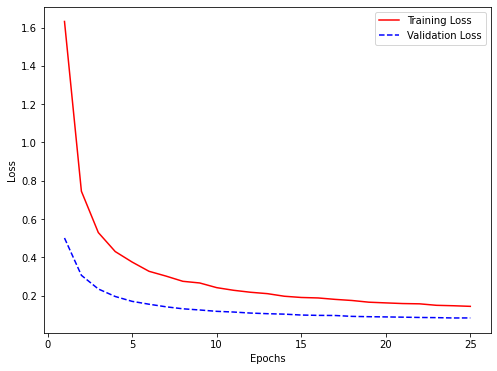

In [13]:
optimizer = cnn_model.getOptimizer(lr=1e-3, wd=0)
classifier_epochs = 25

cnn_model.train()
breaker()
LPT = []
LPV = []

start_time = time()
for e in range(classifier_epochs):
    trainLossPerPass = 0
    valLossPerPass = 0
    for X, y in tr_data:
        X, y = X.to(device), y.to(device).view(-1)

        optimizer.zero_grad()
        output = cnn_model(X)
        loss = nn.NLLLoss()(output, y)
        loss.backward()
        trainLossPerPass += (loss.item()/y.shape[0])
        optimizer.step()
    LPT.append(trainLossPerPass)

    for X, y in ts_data:
        X, y = X.to(device), y.to(device).view(-1)
        with torch.no_grad():
            output = cnn_model(X)
            loss = nn.NLLLoss()(output, y)
            valLossPerPass += (loss.item()/y.shape[0])
    LPV.append(valLossPerPass)
    print("Epoch: {} | Training Loss: {:.5f} | Validation Loss: {:.5f}".format(e+1, trainLossPerPass, valLossPerPass))

breaker()
print("Time : {:.2f} seconds".format(time() - start_time))
breaker()

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation**

In [14]:
cnn_model.eval()

y_pred = torch.zeros(ts_batch_size, 1).to(device)

for X, y in ts_data:
    X = X.to(device)
    with torch.no_grad():
        output = torch.exp(cnn_model(X))
    Pred = torch.argmax(output, dim=1)
    y_pred = torch.cat((y_pred, Pred.view(-1, 1)), dim=0)

y_pred = y_pred[ts_batch_size:].detach().cpu().numpy().reshape(-1)

breaker()
print("Classification Accuracy : {} %".format(accuracy_score(ts_labels, y_pred) * 100))
breaker()


--------------------------------------------------

Classification Accuracy : 95.87958795879588 %

--------------------------------------------------

